# PCA as a Factor Model


### Introduction
Sometimes, to calculate variance of portfolio easily traped into dimensional disaster. PCA is a way to solve this problem. It can estimate portfolio risk by principle component variance of projection so that successed to got dimensionality reduction.

As we learned in the previous lessons, we can use PCA to create a factor model of risk. Our risk factor model represents the return as:

$$
\textbf{r} = \textbf{B}\textbf{f} + \textbf{s}
$$

where $\textbf{r}$ is a matrix containing the asset returns, $\textbf{B}$ is a matrix representing the factor exposures, $\textbf{f}$ is the matrix of factor returns, and $\textbf{s}$ is the idiosyncratic risk (also known as the company specific risk).

In this notebook, we will use real stock data to calculate:

* The Factor Exposures (Factor Betas) $\textbf{B}$
* The Factor Returns $\textbf{f}$
* The Idiosyncratic Risk Matrix $\textbf{S}$
* The Factor Covariance Matrix $\textbf{F}$

We will then combine these quantities to create our Risk Model. 

In [1]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

## load and process data
We load data from a csv file which download from Tushare platform, welcome to read `Toshrae_Coding.ipynb` to check how to get stock data.

In [2]:
# load data from csv
all_stocks = pd.read_csv('20200101-20210101.csv').iloc[:,1:]
universe = all_stocks.sort_index(axis=0, ascending=False)
# convert date to standard string format, easy to filter
universe["date"] = pd.to_datetime(universe["trade_date"], format='%Y%m%d')
universe["date"] = universe.date.apply(lambda x: x.strftime("%Y-%m-%d"))
# drop missing data
universe = universe.dropna()
universe = universe.sort_values(by=["date", "ts_code"]).reset_index(drop=True)

## pickup market cap always above 1000 million tickers

In [39]:
tmp_universe = universe.loc[universe.amount>=1e6].loc[universe.date == '2020-01-02']
tmp_universe

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,date
0,000001.SZ,20200102,16.65,16.95,16.55,16.87,16.45,0.42,2.5532,1530231.87,2571196.482,2020-01-02
1,000002.SZ,20200102,32.80,33.60,32.51,32.56,32.18,0.38,1.1809,1012130.40,3342373.870,2020-01-02
7,000009.SZ,20200102,6.28,6.79,6.19,6.66,6.19,0.47,7.5929,2406170.23,1559130.143,2020-01-02
17,000021.SZ,20200102,12.40,13.17,12.23,12.88,12.18,0.70,5.7471,822238.58,1043003.070,2020-01-02
46,000063.SZ,20200102,35.66,35.80,35.13,35.45,35.39,0.06,0.1695,1014254.88,3592989.149,2020-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...
3322,603259.SH,20200102,92.49,92.78,90.39,91.62,92.12,-0.50,-0.5428,116129.61,1058576.881,2020-01-02
3398,603399.SH,20200102,12.90,13.00,12.15,12.38,13.50,-1.12,-8.2963,957072.16,1181069.496,2020-01-02
3559,603799.SH,20200102,40.43,41.28,38.23,40.13,39.39,0.74,1.8786,601462.02,2391201.520,2020-01-02
3657,603986.SH,20200102,207.01,224.86,206.10,219.53,204.89,14.64,7.1453,99546.53,2167567.315,2020-01-02


In [44]:
# process data
returns_df = universe.pivot(index='date', columns='ts_code', values='close')
returns_df = returns_df.pct_change()[1:].fillna(0)
returns_df = returns_df[tmp_universe.ts_code.values]
returns_df

ts_code,000001.SZ,000002.SZ,000009.SZ,000021.SZ,000063.SZ,000100.SZ,000333.SZ,000338.SZ,000401.SZ,000425.SZ,...,601899.SH,601901.SH,601916.SH,601990.SH,603160.SH,603259.SH,603399.SH,603799.SH,603986.SH,603993.SH
date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.018376,-0.015663,-0.039039,0.100155,0.031030,0.017505,-0.024937,0.016089,-0.004135,-0.003448,...,0.010526,0.005855,-0.004167,-0.034954,-0.003141,-0.025759,-0.087237,0.099676,0.003963,0.025172
2020-01-06,-0.006403,-0.016849,0.100000,0.047283,0.004104,-0.008602,-0.018194,-0.074909,-0.011269,-0.036332,...,0.012500,-0.011641,-0.006276,-0.014173,-0.014920,-0.029801,-0.015929,0.059823,0.025408,0.002232
2020-01-07,0.004687,0.007934,0.017045,-0.013477,-0.002725,-0.008677,0.014860,0.006583,0.017397,0.010772,...,-0.039095,0.016490,0.004211,0.053514,0.011665,0.015127,0.004496,-0.018174,-0.058496,-0.015590
2020-01-08,-0.028571,-0.002519,-0.006983,-0.031421,-0.024317,0.032823,0.003962,-0.034009,-0.033019,-0.014210,...,0.006424,-0.045191,-0.018868,-0.048522,-0.027385,-0.006256,-0.030439,0.008493,0.003384,0.009050
2020-01-09,0.007803,0.016414,-0.012658,0.014104,0.036684,0.012712,0.020075,0.013541,0.019512,0.010811,...,-0.040426,0.019417,0.004274,0.011952,0.028252,0.045101,0.000000,0.006694,0.057611,-0.008969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,-0.012048,0.005727,0.017426,-0.007953,-0.004171,0.011923,0.007428,-0.014945,0.005714,0.000000,...,0.040404,0.032491,0.000000,0.003460,0.012897,0.041997,0.052743,0.100000,-0.031058,0.099593
2020-12-28,0.044900,0.011388,-0.031621,-0.031534,-0.015142,0.011782,0.023723,0.027704,-0.008523,-0.027778,...,0.018339,-0.006993,0.002500,-0.015517,-0.001959,-0.020152,-0.038076,0.020451,0.006116,0.099815
2020-12-29,0.016976,0.003519,-0.002721,0.015453,0.100098,-0.024745,-0.006367,-0.001926,0.025788,0.009524,...,-0.036017,0.005869,0.004988,0.014011,0.057269,0.003104,-0.010417,-0.099948,0.051886,-0.040336


# Create PCA Risk Model
### pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver) 
function uses Scikit-Learn's `PCA()` class to fit the `returns` dataframe with the given number of `num_factor_exposures` (Principal Components) and with the given `svd_solver`. The `returns` parameter is the pandas dataframe of returns .`num_factor_exposures` parameter is an integer representing the number of Principal Components you want to use in your PCA algorithm, number from 1 to all number of return columns. The `svd_solver` parameter is a string that determines the type of solver you want to use in your PCA algorithm. To see the type of solvers that you can use, see the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). The function must fit the `returns` and return the `pca` object. 

### factor_betas and factor_returns
we need to get new beta and new facor returns expressed by pca model. It's different from original data, because PCA model had built a new space to estimate these data.
new betas can be got by `pca.components_.T` and new returns can be got by `pca.transform(returns)`.
New beta and new returns had column numbers determined by how many principle components you will choice

### factor_cov_matrix(self, factor_returns, ann_factor):
To calculate the annualized factor covariance matrix, $\textbf{F}$, we use the following equation:

$$
\textbf{F} = \frac{1}{N -1}\textbf{f}\textbf{f}^T
$$

where, $N$ is the number of elements in $\textbf{f}$. Recall that the factor covariance matrix, $\textbf{F}$, is a diagonal matrix. The `factor_returns` parameter is the output of the `factor_returns()` function. The `ann_factor` parameter is an integer representing the annualization factor. 

**HINT :** You can calculate the factor covariance matrix $\textbf{F}$ very easily using Numpy's `.var` method. The $\frac{1}{N -1}$ factor can be taken into account using the `ddof` keyword. 

### idiosyncratic_var_matrix(self, returns, factor_returns, factor_betas, ann_factor):

Let's review how we can calculate the Idiosyncratic Risk Matrix $\textbf{S}$. We know that: 

$$\textbf{s} = \textbf{r} - \textbf{B}\textbf{f}$$

We refer to $\textbf{s}$ as the residuals. To calculate the idiosyncratic or specific risk matrix $\textbf{S}$, we have to calculate the covariance matrix of the residuals, $\textbf{s}$, and set the off-diagonal elements to zero. 

The `factor_returns` parameter is the output of the `factor_returns()` function. Similarly, the `factor_betas` parameter is the output of the `factor_betas()` function. The `ann_factor` parameter is an integer representing the annualization factor. 

Remember that if the `returns` time series are daily returns, then when we calculate the Idiosyncratic Risk Matrix we will get values on a daily basis. We can annualize these values simply by multiplying the whole Idiosyncratic Risk Matrix by an annualization factor of 252. Remember we don't need the square root of the factor because our numbers here are variances not standard deviations.

In [45]:
import numpy as np

class RiskModel(object):
    def __init__(self, returns, ann_factor, num_factor_exposures):

        self.pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, self.factor_returns_, self.factor_betas_, ann_factor)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, factor_returns, factor_betas, ann_factor):
        estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    


In [46]:
# Set the annualized factor
ann_factor = 252

# Set the number of factor exposures (principal components) for the PCA algorithm
num_factor_exposures = 50

# Set the svd solver for the PCA algorithm
svd_solver = 'full'

# Create a RiskModel object
rm = RiskModel(returns_df, ann_factor, num_factor_exposures)


# Print Model Results

In [47]:
rm.factor_betas_

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
000001.SZ,-0.053166,0.125067,0.025669,0.094686,0.020307,0.017912,-0.021284,0.067331,-0.014054,0.008180,...,-0.001429,0.015077,0.071226,-0.026761,0.063418,0.031772,0.166205,0.047012,0.015509,-0.035782
000002.SZ,-0.041404,0.113508,-0.004855,0.087894,0.025765,0.014185,-0.026356,0.106944,-0.067748,0.021199,...,-0.027164,-0.014739,-0.024867,0.110366,0.004560,0.056572,-0.013722,0.008556,-0.003215,0.150395
000009.SZ,-0.101557,-0.038555,-0.136014,-0.042028,0.075886,-0.021030,-0.070057,-0.025705,0.074462,-0.005986,...,-0.081982,0.019077,-0.069874,0.071992,0.008135,0.048239,0.044384,0.049776,0.066105,-0.115558
000021.SZ,-0.127512,-0.094902,0.069849,-0.109865,0.050371,-0.058399,0.097498,0.003358,-0.033899,-0.057918,...,0.046316,0.127703,-0.022992,-0.125859,-0.000843,-0.163524,-0.030935,0.000374,0.070492,0.160717
000063.SZ,-0.101504,-0.023471,0.024002,0.017696,-0.051819,-0.018250,-0.086470,0.096487,-0.071317,0.017255,...,-0.044550,0.166550,-0.085621,-0.131132,-0.118908,-0.033521,-0.163122,-0.003012,-0.057337,-0.007897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603259.SH,-0.066700,0.019133,-0.148031,-0.104915,-0.199216,0.084900,0.063449,-0.056157,-0.119413,-0.036981,...,0.029902,-0.123032,0.020124,0.065283,-0.073297,0.004299,0.127371,-0.053769,0.050051,0.062746
603399.SH,-0.045119,0.067323,0.032078,-0.123579,0.049885,-0.129235,0.002186,0.096615,-0.052546,0.111210,...,-0.077500,0.061347,-0.032566,-0.117845,-0.032664,-0.194671,0.071185,0.107665,-0.103820,0.021207
603799.SH,-0.098842,0.018822,-0.234467,-0.013552,0.333504,-0.072799,0.022729,0.027277,-0.033785,-0.017002,...,-0.149739,0.058204,-0.228193,0.028220,-0.163798,0.067392,-0.000338,-0.053234,0.090860,0.095227
603986.SH,-0.121403,-0.156044,0.095632,0.141268,0.012728,0.277171,0.003045,0.173346,-0.068060,0.047645,...,0.209981,0.101825,0.014110,-0.019977,0.114396,0.034840,0.083804,-0.036065,0.063667,-0.033820


In [48]:
# Display the Factor Returns
rm.factor_returns_

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.005975,-0.030812,-0.031544,0.036080,0.085932,-0.041095,0.086600,-0.047001,-0.006126,-0.017974,...,-0.033765,0.022497,0.003282,0.008068,-0.023689,0.034684,-0.008686,0.005572,-0.014061,0.010902
2020-01-06,-0.069625,-0.104904,-0.094117,-0.031147,0.121184,-0.012669,-0.009753,-0.011809,0.036699,-0.047255,...,0.051184,0.001623,0.000945,0.048862,0.009275,-0.020415,0.011667,-0.010153,0.011372,-0.007151
2020-01-07,-0.032865,0.069495,0.023543,-0.070719,-0.052433,-0.033121,0.049750,-0.079714,-0.004290,0.045940,...,0.017643,-0.008430,0.017501,-0.011431,-0.008965,0.009070,-0.002956,-0.012327,-0.023804,0.005220
2020-01-08,0.229534,-0.053573,-0.064792,0.031351,0.011214,-0.027409,0.027999,-0.000910,0.066442,0.075540,...,-0.037074,0.035189,-0.038598,-0.004918,0.014028,-0.003779,-0.002753,0.015132,0.001183,0.017525
2020-01-09,-0.179006,-0.025763,0.028402,0.086506,-0.055383,0.011154,0.014386,-0.001153,-0.015437,-0.003346,...,-0.009134,-0.012664,0.017599,-0.033937,-0.013203,-0.018530,0.030793,0.001672,-0.016314,0.014570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,-0.089929,0.012338,-0.118588,-0.018093,0.146733,-0.007517,-0.011029,0.001465,0.013206,0.038521,...,0.009578,-0.014938,0.001870,-0.009661,0.000229,0.031244,-0.005788,-0.021550,-0.028171,0.021867
2020-12-28,0.087237,0.092018,-0.127308,-0.040962,0.006430,0.043991,-0.061605,0.036562,-0.060704,-0.004048,...,-0.000424,0.057507,0.010886,-0.013618,0.004106,-0.003963,0.006079,0.035942,0.011375,-0.026389
2020-12-29,-0.034750,-0.035956,0.207797,-0.025885,-0.176587,-0.066568,-0.077993,0.078872,-0.003285,0.057325,...,-0.042871,-0.014108,-0.051573,-0.007555,-0.025171,-0.009403,0.000721,0.000080,0.009819,-0.034028


In [49]:
# Display the Idiosyncratic Risk Matrix
rm.idiosyncratic_var_matrix_

ts_code,000001.SZ,000002.SZ,000009.SZ,000021.SZ,000063.SZ,000100.SZ,000333.SZ,000338.SZ,000401.SZ,000425.SZ,...,601899.SH,601901.SH,601916.SH,601990.SH,603160.SH,603259.SH,603399.SH,603799.SH,603986.SH,603993.SH
ts_code,,,,,,,,,,,,,,,,,,,,,
000001.SZ,0.018934,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
000002.SZ,0.000000,0.023139,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
000009.SZ,0.000000,0.000000,0.026213,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
000021.SZ,0.000000,0.000000,0.000000,0.016801,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
000063.SZ,0.000000,0.000000,0.000000,0.000000,0.033526,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603259.SH,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.021328,0.000000,0.000000,0.000000,0.000000
603399.SH,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.017473,0.000000,0.000000,0.000000
603799.SH,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.016653,0.000000,0.000000


In [50]:
# Display the Factor Covariance Matrix
print(rm.factor_cov_matrix_.shape)
rm.factor_cov_matrix_

(50, 50)


array([[11.41568284,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.76375951,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.10394365, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.11003954,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.10652626,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.10318409]])

# View The Percent of Variance Explained by Each Factor
You can see that the first factor dominates. The precise defintion of each factor in a latent model is unknown, however we can guess at the likely intepretation.

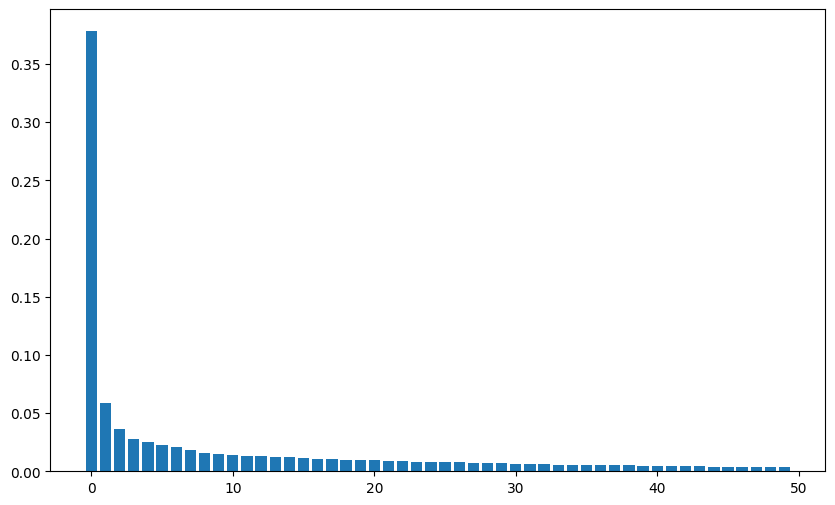

In [51]:
%matplotlib inline

import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [10.0, 6.0]

# Make the bar plot
plt.bar(np.arange(num_factor_exposures), rm.pca.explained_variance_ratio_);

# View The Factor Returns

Remember that the factors returns don't necessarily have direct interpretations in the real world but you can thinik of them as returns time series for some kind of latent or unknown driver of return variance. 

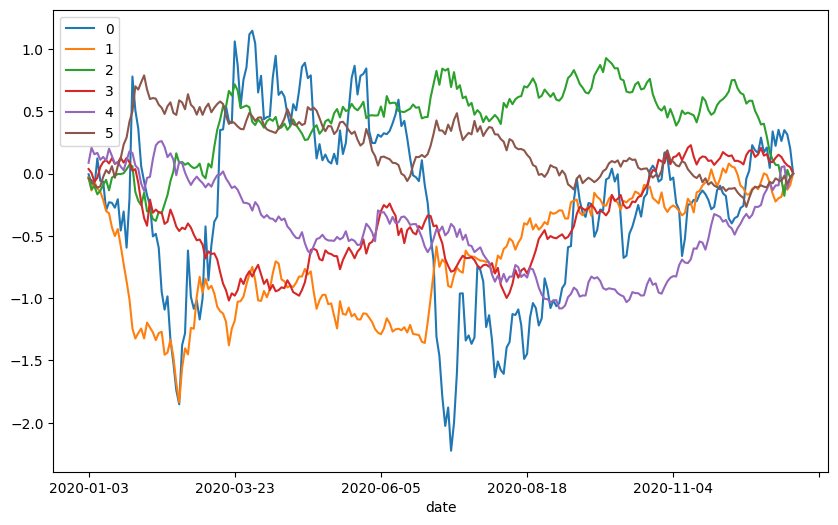

In [53]:
%matplotlib inline

import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [10.0, 6.0]

rm.factor_returns_.loc[:,0:5].cumsum().plot();